In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



C:\Users\yunus\Anaconda3\envs\GPU_ENV\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


- uncomment to install library

In [2]:
#! pip install pydot

In [3]:
#! pip install graphviz 

___
# 0. Setup Experiment

- set parameter

In [4]:
labels = ['AF', 'N']

fs = 250

sample_size = 6 # 6s

feature_pad = 15 # set 15 if using 6s, set 50 if using 16s

# feature_type supported parameter 
# 'qrs_complex' / 'rr_interval' / 'qt_interval'
# 'qrs_complex,rr_interval' / 'qrs_complex,qt_interval' / 'rr_interval,qt_interval'
# 'qrs_complex,rr_interval,qt_interval'
feature_type = "rr_interval" 

threshold_acc = 0.97

test_size_split=0.15

EPOCHS = 10

BATCH_SIZE = 32

In [5]:
import os
import datetime

experiment_folder = "experiment/"

experiment_name = feature_type + "_" + datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

if not os.path.exists(experiment_folder + experiment_name) :
    os.mkdir(experiment_folder + experiment_name)

___
# 1. Load Feature Dataset

In [6]:
dataset_folder = 'dataset/'

filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_feature_") > -1:
        filenames.append(filename)

In [7]:
filenames

['test_all_feature_qrs_complex.csv',
 'test_all_feature_qt_interval.csv',
 'test_all_feature_rr_interval.csv',
 'train_all_feature_qrs_complex.csv',
 'train_all_feature_qt_interval.csv',
 'train_all_feature_rr_interval.csv']

In [8]:
selected_feature_len = len(feature_type.split(sep=","))
test_dfs = []
train_dfs = []

for i, feature in enumerate(feature_type.split(sep=",")):
    print("Reading feature %s..." % feature)
    test = pd.read_csv(dataset_folder + "test_all_feature_%s.csv" % feature, header=None)
    train = pd.read_csv(dataset_folder + "train_all_feature_%s.csv" % feature, header=None)
    if i < (selected_feature_len - 1) :
        test = test.drop(30, 1)
        train = train.drop(30, 1)
    test_dfs.append(test)
    train_dfs.append(train)
    
test_df = pd.concat(test_dfs, axis=1, ignore_index=True)
train_df = pd.concat(train_dfs, axis=1, ignore_index=True)

Reading feature rr_interval...


- merge dataset

In [9]:
featurs_dfs = pd.concat([test_df, train_df])

In [10]:
featurs_dfs.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,274.0,274.0,288.0,156.0,138.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,263.0,254.0,265.0,264.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,208.0,113.0,151.0,162.0,173.0,155.0,206.0,182.0,0.0,0.0,...,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,146.0,146.0,146.0,142.0,142.0,143.0,141.0,138.0,140.0,0.0,...,140.0,141.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,132.0,136.0,134.0,134.0,132.0,132.0,136.0,138.0,136.0,0.0,...,137.0,137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
X = featurs_dfs.values[:, :feature_pad*2*selected_feature_len].reshape(-1, feature_pad*2*selected_feature_len, 1)
y = featurs_dfs.values[:, feature_pad*2*selected_feature_len]

In [12]:
X.shape, y.shape

((8492, 30, 1), (8492,))

In [13]:
np.mean(X)

80.77922358298007

# 2. Splitting Dataset

- convert to categorical

In [14]:
enc = OneHotEncoder()
enc.fit(y.reshape(-1, 1))
print("Categories :", enc.categories_[0])
y_categorical = enc.transform(y.reshape(-1, 1)).toarray()

Categories : [0. 1.]


In [15]:
print("splitting dataset, %d%% for testing dan %d%% for training" % (test_size_split*100 , (1-test_size_split)*100))

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y_categorical, 
                                    test_size=test_size_split,
                                    random_state=42)

print("dataset size after splitting :")
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

splitting dataset, 15% for testing dan 85% for training
dataset size after splitting :
(7218, 2) (7218, 30, 1) (1274, 2) (1274, 30, 1)


# 3. Utils Function

In [16]:
import json

def writeJson_config(Path, Name, Data, append):
    mode = 'a+' if append else 'w'
    full_path = Path + Name

    with open(full_path, mode=mode) as json_config:
        json.dump(Data, json.load(json_config) if append else json_config, indent=4, sort_keys=True)
    
    return 'success' 


In [17]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig(experiment_folder + experiment_name +
               "/plot-confusion-matrix-%s.png" % feature_type)
    
    plt.show()

In [18]:
def evaluate_model(history):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid()
    plt.show()
    fig1.savefig(experiment_folder + experiment_name +
               "/plot-accuracy-%s.png" % feature_type)
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()
    fig2.savefig(experiment_folder + experiment_name +
               "/plot-loss-%s.png" % feature_type)

# 4. Building Convolutional Neural Network

- Import Keras library

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
#from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow import keras

from keras.utils import plot_model


Using TensorFlow backend.


- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [20]:
def cnn_model(max_len):
    model = Sequential()
    
    model.add(Conv1D(filters=32,
                     kernel_size=2,
                     activation='relu',
                     padding='same',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
    
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=8` yang artinya jika proses training untuk 8 epoch tidak terjadi peningkatan maka hentikan proses training.

In [21]:
def check_model(model_, x, y, x_test, y_test, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath='cnn_classif_best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      shuffle=True,
                      #validation_split=0.15)
                      validation_data=(x_test, y_test))
    #model_.load_weights('cnn_classif_best_model.h5')
    return hist 

# 5. Train Model CNN

- jalankan proses training dengan `EPOCH` sebanyak 16 dan `BATCH_SIZE` sebesar 32

In [22]:
max_len = X_train[0].shape[0]

model = cnn_model(max_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 32)             3104      
__________

- Save model arhitecture

In [23]:
with open(experiment_folder + experiment_name +
              '/model_summary_%s.txt' % feature_type, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

- Train model

In [24]:
history=check_model(model, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE)


Train on 7218 samples, validate on 1274 samples
Epoch 1/10
7218/7218 [==============================] - 17s 2ms/step - loss: 0.2396 - acc: 0.9106 - val_loss: 0.1506 - val_acc: 0.9576
Epoch 2/10
7218/7218 [==============================] - 11s 2ms/step - loss: 0.1374 - acc: 0.9565 - val_loss: 0.1029 - val_acc: 0.9655
Epoch 3/10
7218/7218 [==============================] - 8s 1ms/step - loss: 0.1285 - acc: 0.9595 - val_loss: 0.1056 - val_acc: 0.9623
Epoch 4/10
7218/7218 [==============================] - 8s 1ms/step - loss: 0.1187 - acc: 0.9634 - val_loss: 0.0891 - val_acc: 0.9710
Epoch 5/10
7218/7218 [==============================] - 7s 991us/step - loss: 0.1150 - acc: 0.9665 - val_loss: 0.1031 - val_acc: 0.9670 loss: 0.1154 - acc: 0.9
Epoch 6/10
7218/7218 [==============================] - 7s 994us/step - loss: 0.1103 - acc: 0.9665 - val_loss: 0.1041 - val_acc: 0.9670
Epoch 7/10
7218/7218 [==============================] - 6s 779us/step - loss: 0.1070 - acc: 0.9662 - val_loss: 0.1226 

- Save model binary

In [25]:
model.save(experiment_folder + experiment_name + "/CNN_Classification_model_%s.h5" % feature_type)

In [43]:
plot_model(model, to_file='model_%s.png' % feature_type, show_shapes=True, show_layer_names=False, rankdir='TB')

- save model training history (log)

In [27]:
pd.DataFrame.from_dict(history.history).to_csv( experiment_folder + experiment_name +
                                               '/history_train_CNN_feature_%s.csv' % feature_type, index=False)

# 6. Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs

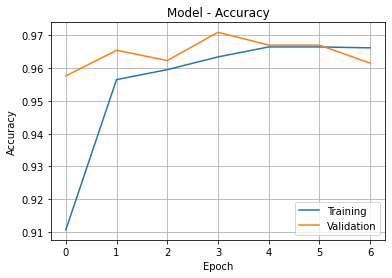

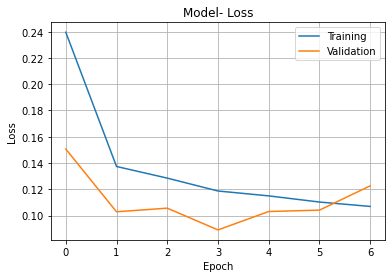

In [28]:
evaluate_model(history)    

- Plot Confusion Matrix

In [29]:
# predict test data
y_pred=model.predict(X_test)

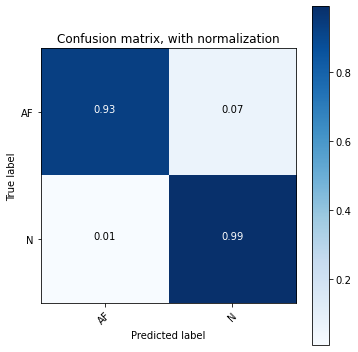

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix, with normalization')

- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

- Plot Classification Report

In [31]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       0.99      0.93      0.96       666
           N       0.93      0.99      0.96       608

    accuracy                           0.96      1274
   macro avg       0.96      0.96      0.96      1274
weighted avg       0.96      0.96      0.96      1274



- Jika kita lihat, nilai report untuk seluruh klas juga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada sclass tersebut 

- save report

In [32]:
report_dict = classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N'],
                            output_dict=True)

writeJson_config(experiment_folder + experiment_name + "/", 
                 "report-%s.json" % feature_type, report_dict, False)

'success'

- save model spec

In [33]:
model_spec_dict = {}
model_spec_dict['train_size'] = [y_train.shape, X_train.shape]
model_spec_dict['test_size'] =  [y_test.shape, X_test.shape]
model_spec_dict['epoch'] =  EPOCHS
model_spec_dict['batch_size'] =  BATCH_SIZE
model_spec_dict['test_size_split'] = test_size_split
model_spec_dict['sample_size'] = sample_size
model_spec_dict['feature_pad'] = feature_pad

writeJson_config(experiment_folder + experiment_name + "/", 
                 "model-spec-%s.json" % feature_type, model_spec_dict, False)

'success'

- Update Experiment Header

In [34]:
with open(experiment_folder + 
              '/experiment_header.txt', 'a') as f:
    f.write("Experiment Name \t: %s \n" % experiment_name)
    f.write("Accuracy \t\t: %.4f\n\n\n" % report_dict['accuracy'])

- calculate statistical feature

In [35]:
statistical_summary = {}

for i, feature in enumerate(feature_type.split(sep=",")):
    dfs = pd.concat([test_dfs[i], train_dfs[i]])
    dfs_x = dfs.values[:, :feature_pad*2]
    statistical_summary[feature] = {}
    statistical_summary[feature]['mean'] = np.mean(dfs_x)
    statistical_summary[feature]['median'] = np.median(dfs_x)
    statistical_summary[feature]['min'] = np.min(dfs_x)
    statistical_summary[feature]['max'] = np.max(dfs_x)

In [36]:
statistical_summary

{'rr_interval': {'mean': 80.77922358298007,
  'median': 0.0,
  'min': 0.0,
  'max': 818.0}}

In [37]:
writeJson_config(experiment_folder + experiment_name + "/", 
                 "statistical_summary-%s.json" % feature_type, statistical_summary, False)

'success'

- move best experiment to main dir (>= threshold accuracy)

In [38]:
if report_dict['accuracy'] >= threshold_acc:
    import shutil
    
    shutil.copy(experiment_folder + experiment_name + "/plot-accuracy-%s.png" % feature_type, "5. plot-accuracy-%s.png" % feature_type)
    shutil.copy(experiment_folder + experiment_name + "/plot-loss-%s.png" % feature_type, "5. plot-loss-%s.png" % feature_type)
    shutil.copy(experiment_folder + experiment_name + "/plot-confusion-matrix-%s.png" % feature_type, "5. plot-confusion-matrix-%s.png" % feature_type)
    shutil.copy(experiment_folder + experiment_name + "/history_train_CNN_feature_%s.csv" % feature_type, "history_train_CNN_feature_%s.csv" % feature_type)
    shutil.copy(experiment_folder + experiment_name + "/report-%s.json" % feature_type, "classification-report-%s.json" % feature_type)
    shutil.copy(experiment_folder + experiment_name + "/CNN_Classification_model_%s.h5" % feature_type, "CNN_Classification_model_%s.h5" % feature_type)
    shutil.copy(experiment_folder + experiment_name + "/statistical_summary-%s.json" % feature_type, "statistical_summary-%s.json" % feature_type)
    print("[INFO] success move best result to main dir!")
else :
    print("[INFO] accuracy %.4f, is under threshold !" % report_dict['accuracy'])

[INFO] accuracy 0.9615, is under threshold !
